<a href="https://colab.research.google.com/github/grizzler88/Springboard/blob/master/Capstone%20-%20Craft%20Beer/CraftBeer_04_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone 3: Craft Beer Recommendation 

#Modelling (Part 4) 

## Import Packages and Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [ ]:
df = pd.read_csv('beers_eda.csv', keep_default_na=False)

In [ ]:
df.drop(columns='Unnamed: 0', inplace=True)

In [ ]:
#df.head()

## Pre-processing

This section is to set up our data so it is ready for modelling.

### Removing Missing Values

Throughout our analysis, we've known that certaion fields have contained 'N/A' values - mainly in relation to Brewery Location, Brewery Type and Beer Availability data.

We wanted to our analyse first to see if it added any insight before making a decision to either drop the rows (and keep the columns) or drop the columns (and keep the rows). Our analysis has shown that a number of columns that contain 'N/A' also look to be worth including in our final modeling, including:
* brewery_region
* brewery_area
* brewery_bar
* beer_availability

To continue to include these as features in our models we will first have to drop the rows which contain null values. This is done below.

In [ ]:
print('Number of n/a in Beer Avaialability: ', df[df.beer_availability == 'N/A']['beer_availability'].count())
print('Number of n/a in Brewery Type: ', df[df.brewery_na == 1]['brewery_na'].count())
print('Number of n/a in Brewery Region: ', df[df.brewery_region == 'N/A']['brewery_region'].count())

Number of n/a in Beer Avaialability:  2975
Number of n/a in Brewery Type:  6363
Number of n/a in Brewery Region:  6363


In [ ]:
missing_data = df.loc[ (df.beer_availability == 'N/A') | (df.brewery_na == 1) | (df.brewery_region == 'N/A') ]

In [ ]:
missing_data.shape

(8874, 26)

In [ ]:
missing_data['cluster_target'].value_counts(normalize=True)

0    0.920216
1    0.079784
Name: cluster_target, dtype: float64

In [ ]:
df = df.loc[ (df.beer_availability != 'N/A') & (df.brewery_na != 1) & (df.brewery_region != 'N/A') ]

In [ ]:
df.shape

(57171, 26)

In [ ]:
df.cluster_target.value_counts(normalize=True)

0    0.945025
1    0.054975
Name: cluster_target, dtype: float64

In [ ]:
df.cluster_target.value_counts()

0    54028
1     3143
Name: cluster_target, dtype: int64

### Dataset for Comparison Later

We will want to compare are model vs real result later on (i.e. average scores and number of reviews) so we will create a copy of the dataset while it still contains these data points.

In [ ]:
df_compare = df

### Dropping Columns

Throughout the analysis, we have looked through the various different columns in the data to gather whether we beleive they will add value to our modelling. Based on the EDA to date, we believe it makes sense to delete the following columns (with reason in brackets):

* beer_name (too many dimensions)
* brewery_name (too many dimensions)
* beer_style_detail (captured by beer_type and beer_style)
* beer_retired (not actionable)
* brewery_city (captured by beer_region and beer_area)
* brewery_state (captured by beer_region and beer_area)
* brewery_country (captured by beer_region and beer_area)
* brewery_beertogo (highly correlated with brewery_bar)
* brewery_eatery (highly correlated with brewery_bar)
* brewery_brewery (not significatn in analysis)
* brewery_homebrew (not significatn in analysis)
* brewery_store (not significatn in analysis)
* brewery_na (null values)
* cluster (captured in target variable)
* number_reviews (captured in target variable)
* mean_score (captured in target variable)
* std_score (captured in target variable)
* review_recency (captured in target variable)

Below we have looked to remove these.

In [ ]:
#df.columns

In [ ]:
drop_list = ['brewery_name', 'beer_name', 'beer_style_detail', 
       'brewery_city', 'brewery_state', 'brewery_country', 
       'beer_retired', 'brewery_beertogo', 'brewery_brewery',
       'brewery_eatery', 'brewery_homebrew', 'brewery_store', 'brewery_na',
       'number_reviews', 'mean_score', 'std_score', 'recency_review',
       'cluster']

In [ ]:
df.drop(columns=drop_list, inplace=True)

In [ ]:
#df.head()

### Creating Dummy Values

Lastly, we will turn our remaining categorical variables into dummy variable to allow them be used in our modelling.

In [ ]:
dummy_beer_type = pd.get_dummies(df.beer_type, prefix='type', drop_first=True)
dummy_beer_style = pd.get_dummies(df.beer_style, prefix='style', drop_first=True)
dummy_brewery_region = pd.get_dummies(df.brewery_region, prefix='region', drop_first=True)
dummy_brewery_area = pd.get_dummies(df.brewery_area, prefix='area', drop_first=True)
dummy_beer_availability = pd.get_dummies(df.beer_availability, prefix='availability', drop_first=True)

In [ ]:
df = pd.concat([df, dummy_beer_type, dummy_beer_style, dummy_beer_availability, dummy_brewery_region, dummy_brewery_area], axis=1).drop(columns=['beer_type', 'beer_style', 'brewery_region', 'brewery_area', 'beer_availability'])

In [ ]:
df.sample(10)

,beer_abv,brewery_bar,cluster_target,type_Lager,style_Brown Ale,style_Dark Ale,style_Dark Lager,style_Hybrid Beer,style_IPA,style_Pale Ale,style_Pale Lager,style_Porter,style_Speciality Beer,style_Stout,style_Strong Ale,style_Wheat Beer,style_Wild / Sour Beer,availability_Rotational,availability_Year Round,region_Europe,region_ROW,region_USA,area_California,area_Canada,area_Colorado,area_Europe,area_Germany,area_Massachusetts,area_Michigan,area_New York,area_Oregon,area_Pennsylvania,area_ROW,area_USA,area_United Kingdom,area_Wisconsin
635,5.200000,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
62494,8.500000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
39931,6.000000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
12426,9.180000,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
32111,4.500000,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
31810,6.500000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
263,6.800000,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
39762,5.800000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
64614,4.400000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
32436,5.905366,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
df.shape

(57171, 36)

### Train / Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df.drop(['cluster_target'], axis=1)
y = df['cluster_target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=293)

### Scaling Data

In [ ]:
X_train_dummy = X_train.drop(columns='beer_abv')
X_test_dummy = X_test.drop(columns='beer_abv')

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=list(X_train.columns))
X_test_scaled = pd.DataFrame(X_test_scaled, columns=list(X_test.columns))

In [ ]:
X_train = pd.concat([X_train_scaled['beer_abv'], X_train_dummy.reset_index().drop(columns='index')], axis=1)
X_test = pd.concat([X_test_scaled['beer_abv'], X_test_dummy.reset_index().drop(columns='index')], axis=1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(42878, 35)
(14293, 35)


### Rebalancing the Data

As we saw earlier, our target class is imbalanced with 3,143 (1) to 54,028 (0). This imblance can impact on the learning phase and the subsequent prediction of machine learning algorithms we look to apply. In general the greater the imbalanced ratio, the decision function will favor the class with the larger number of samples (referred as the majority class).

To avoid this issue impacting on our modelling we will look to rebalance our dataset using random sampling. This is process where we look to balance our training dataset by either randomly reducing our majority class samples (Under Sampling) or randomly increasing our minority class samples (Over Sampling). For our data, we will focus on Over Sampling.  

The simplest way to do this is to generate new samples by randomly sampling with replacement the current available samples. This can done using imbalanced learn (imblearn) RandomOverSampler function. Another approach to this is using either the SMOTE and ADASYN function in imblearn's package which generate new samples by interpolation. 

For the purposes of this project, we will using the SMOTE fucntion.

https://imbalanced-learn.org/stable/introduction.html 

https://imbalanced-learn.org/stable/over_sampling.html

https://imbalanced-learn.org/stable/common_pitfalls.html

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=354)

X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_train_resampled = pd.DataFrame(X_train_resampled, columns=list(X_train.columns))

In [ ]:
X_train_resampled.shape

(81064, 35)

In [ ]:
y_train_resampled.shape

(81064,)

### Recursive Feature Engineering

Lastly, we want to see if we can reduce the number of features in our dataset before applying it to our models.

To do this, we will apply Recursive Feature Engineering model that identifies the optimal number of features by repeately running a model to measure performance and rank features and dropping the least important feature until it runs out features. This will then suggest the optimal number of features based on the performance


To do this, we will apply Recursive Feature Engineering model that identifies the optimal number of features by recursively considering smaller and smaller sets of features. Intially, the model is estimated on all featues and the importance of each is ranked - with the lowest being dropped. This process continues until there is no more features remaing. The optimal number of features is then decided by the model which performs best - in our cases this is accuracy.

The results of the model suggest 29 features is the optimatl with 7 features being dropped:
* area_Canada 
* area_United Kingdom 
* style_Wheat Beer
* region_USA
* style_Strong Ale 
* area_Germany

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

estimator = GradientBoostingClassifier(random_state=41)
cv = StratifiedKFold(n_splits=3, random_state=368)
rfecv = RFECV(estimator, step=1, scoring='accuracy', cv=cv)
rfecv.fit(X_train_resampled, y_train_resampled)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RFECV(cv=StratifiedKFold(n_splits=3, random_state=368, shuffle=False),
      estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='deviance',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                           presort='deprecated',
                                           

In [ ]:
cols = rfecv.get_support(indices=True)

X_rfecv = X_train_resampled.iloc[:,cols]

X_rfecv.head()
X_rfecv.shape
#X_rfecv.columns

(81064, 29)

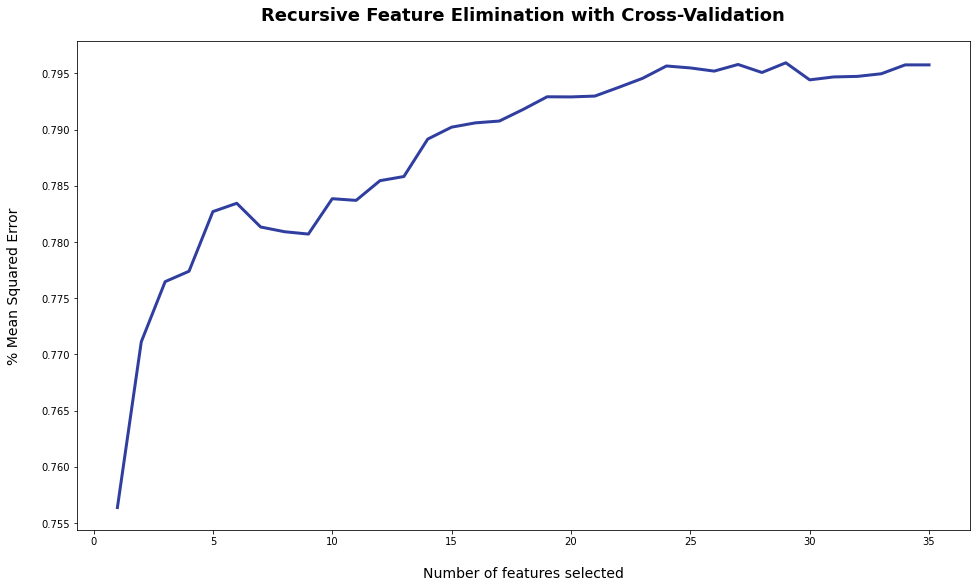

Optimal number of features : 29


In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Mean Squared Error', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

print("Optimal number of features : %d" % rfecv.n_features_)

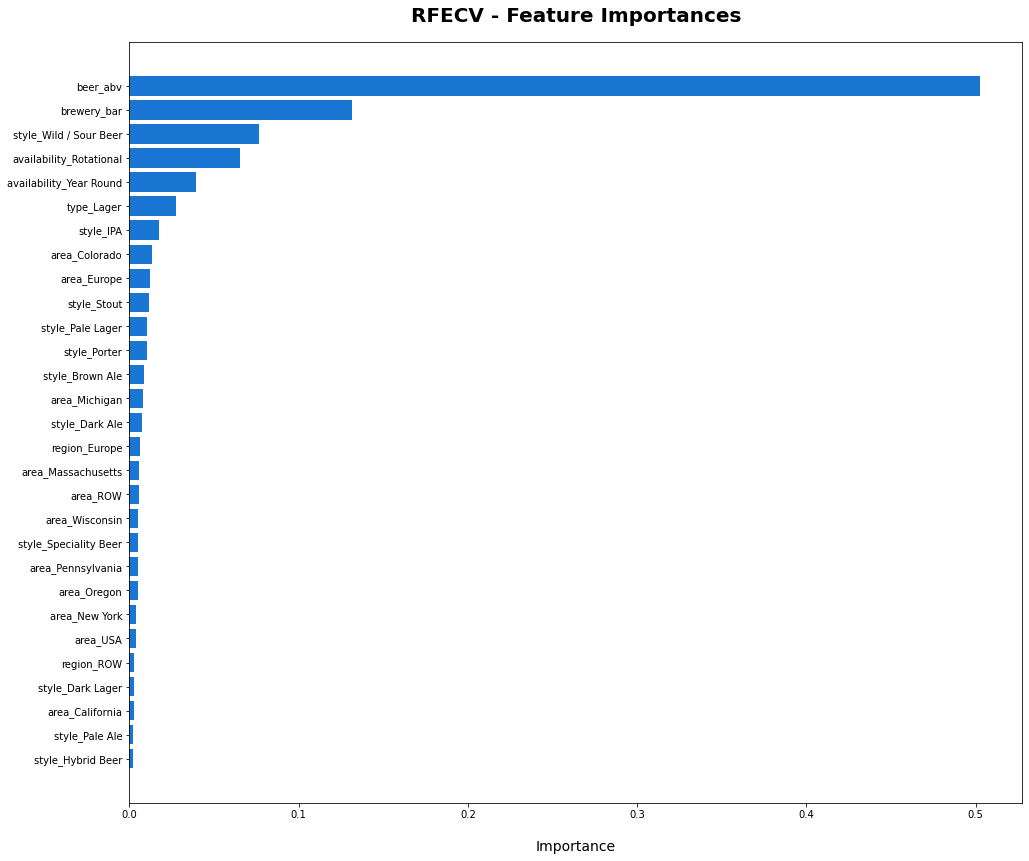

In [ ]:
dset = pd.DataFrame()
dset['attr'] = X_rfecv.columns
dset['importance'] = np.absolute(rfecv.estimator_.feature_importances_)

dset = dset.sort_values(by='importance', ascending=True)

plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [ ]:
#rfecv.support_
#rfecv.ranking_

In [ ]:
drop_cols = list(set(X_train_resampled.columns).difference(X_rfecv.columns))
print(drop_cols)

['style_Strong Ale', 'area_United Kingdom', 'style_Wheat Beer', 'area_Canada', 'region_USA', 'area_Germany']


### Final Data for Modelling

In [ ]:
X_train = rfecv.transform(X_train_resampled)
X_test = rfecv.transform(X_test)

In [ ]:
y_train = y_train_resampled

## Modelling

Now that are data is ready - we can begin to model our data!

Our target for this analysis is the 'target_cluster' variable (y) which groups beers into two groups based on their average review score, number of reviews and recency of their reviews.

The aim is to create a model that predict what type of beer is most likely to fit into this category. To achieve this, we have identified 29 features that include information on the beer's style and alcohol level, as well as the type and location of the brewery in which it was produced. To do this, I've identified four models to apply the data to - this includes:
1. Logistic Regression
2. SGD Classifier
3. Gradient Boosting
4. Random Forest

In the coming sections, we will look to apply these models to the data. In the sections following, we will look to hypertune the models which worked best before deciding on our final model.

### Logistic Regression

Logistic regression is a linear model for classification (not regression despite the name). In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression 

For our first run of each of these models, we will not tune them and go with default settings. Based on the results of these tests, we can then look at which models to continue to work with.

The results of the first run of this model show the model has an accuracy score 0.73, a precision score 0.73, and recall 0.72. These results hold as the model is applied to 5-fold cross-validation.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(random_state=31)
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=31, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = logreg.predict(X_train)

#### Confusion Matrix and Classification Report

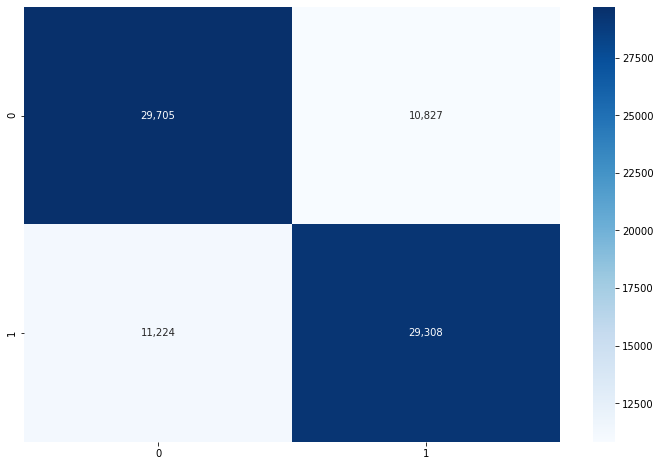

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     40532
           1       0.73      0.72      0.73     40532

    accuracy                           0.73     81064
   macro avg       0.73      0.73      0.73     81064
weighted avg       0.73      0.73      0.73     81064



#### Accuracy, Precision, and Recall

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

print('Accuracy Score:', round(accuracy_score(y_train, y_pred), 2))
print('Precision Score:', round(precision_score(y_train, y_pred), 2))
print('Recall Score:', round(recall_score(y_train, y_pred), 2))
print('ROC AUC Score:', round(roc_auc_score(y_train, y_pred), 2))

Accuracy Score: 0.73
Precision Score: 0.73
Recall Score: 0.72
ROC AUC Score: 0.73


#### 5-fold Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

accuracy_cv = cross_val_score(logreg, X_train ,y_train ,cv=5 ,scoring='accuracy')
precision_cv = cross_val_score(logreg, X_train ,y_train ,cv=5 ,scoring='precision')
recall_cv = cross_val_score(logreg, X_train ,y_train ,cv=5 ,scoring='recall')
roc_auc_cv = cross_val_score(logreg, X_train ,y_train ,cv=5 ,scoring='roc_auc')

logreg_accuracy_cv = abs(accuracy_cv.mean())
logreg_precision_cv = abs(precision_cv.mean())
logreg_recall_cv = abs(recall_cv.mean())
logreg_roc_auc_cv = abs(roc_auc_cv.mean())

print('Accuracy (CV mean) :', round(logreg_accuracy_cv, 2))
print('Precision (CV mean) :', round(logreg_precision_cv, 2))
print('Recall (CV mean) :', round(logreg_recall_cv, 2))
print('ROC AUC (CV mean) :', round(logreg_roc_auc_cv, 2))

Accuracy (CV mean) : 0.73
Precision (CV mean) : 0.73
Recall (CV mean) : 0.72
ROC AUC (CV mean) : 0.8


### SGD Classifier

Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to fitting linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression. The advantages of Stochastic Gradient Descent are it's efficiency and ease of implementation. Disadvantages ard SGD requires a number of hyperparameters (such as the regularization parameter and the number of iterations) and SGD is sensitive to feature scaling.

https://scikit-learn.org/stable/modules/sgd.html# 

On first run, SGD Classifer performs similarly to the Logistic Regression acheiving an Accuarcy (0.73), Precision (0.72) and Recall (0.73). Accuracy and Recall both drop when we apply cross-validation but Precision increases.


In [ ]:
from sklearn.linear_model import SGDClassifier

sgdclass = SGDClassifier(random_state=31)
sgdclass.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=31, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred = sgdclass.predict(X_train)

#### Confusion Matrix and Classification Report

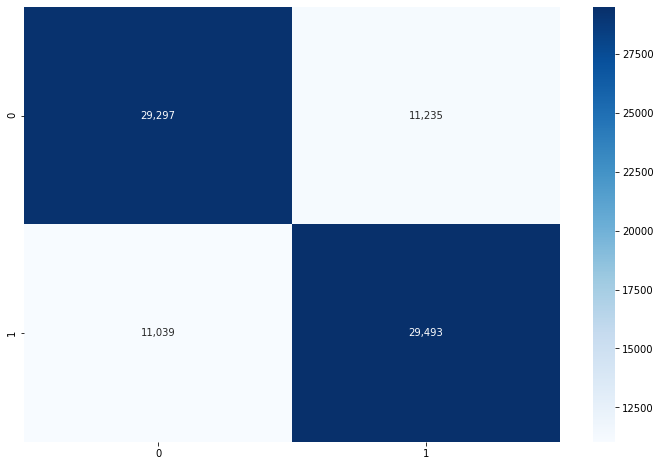

In [ ]:
cm = confusion_matrix(y_train, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.72     40532
           1       0.72      0.73      0.73     40532

    accuracy                           0.73     81064
   macro avg       0.73      0.73      0.73     81064
weighted avg       0.73      0.73      0.73     81064



#### Accuracy, Precision, and Recall

In [ ]:
print('Accuracy Score:', round(accuracy_score(y_train, y_pred), 2))
print('Precision Score:', round(precision_score(y_train, y_pred), 2))
print('Recall Score:', round(recall_score(y_train, y_pred), 2))
print('ROC AUC Score:', round(roc_auc_score(y_train, y_pred), 2))

Accuracy Score: 0.73
Precision Score: 0.72
Recall Score: 0.73
ROC AUC Score: 0.73


#### 5-fold Cross Validation

In [ ]:
accuracy_cv = cross_val_score(sgdclass, X_train ,y_train ,cv=5 ,scoring='accuracy')
precision_cv = cross_val_score(sgdclass, X_train ,y_train ,cv=5 ,scoring='precision')
recall_cv = cross_val_score(sgdclass, X_train ,y_train ,cv=5 ,scoring='recall')
roc_auc_cv = cross_val_score(sgdclass, X_train ,y_train ,cv=5 ,scoring='roc_auc')

sgd_accuracy_cv = abs(accuracy_cv.mean())
sgd_precision_cv = abs(precision_cv.mean())
sgd_recall_cv = abs(recall_cv.mean())
sgd_roc_auc_cv = abs(roc_auc_cv.mean())

print('Accuracy (CV mean) :', round(sgd_accuracy_cv, 2))
print('Precision (CV mean) :', round(sgd_precision_cv, 2))
print('Recall (CV mean) :', round(sgd_recall_cv, 2))
print('ROC AUC (CV mean) :', round(sgd_roc_auc_cv, 2))

Accuracy (CV mean) : 0.72
Precision (CV mean) : 0.73
Recall (CV mean) : 0.71
ROC AUC (CV mean) : 0.79


### Naive Bayes

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Naive Bayes learners and classifiers can be extremely fast compared to more sophisticated methods. On the flip side, although naive Bayes is known as a decent classifier, it is known to be a bad estimator, so the probability outputs from predict_proba are not to be taken too seriously.

https://scikit-learn.org/stable/modules/naive_bayes.html#gaussian-naive-bayes 

First run of the model underperforms compared to Logistic and SGD classifier with Accuracy (0.65), Precions (0.6), and Recall (0.87). These results hold under cross-validation.

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred = nb.predict(X_train)

#### Confusion Matrix & Classification Report

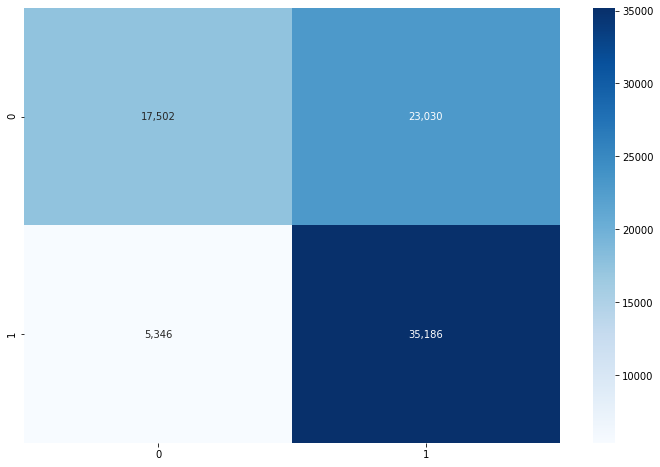

In [ ]:
cm = confusion_matrix(y_train, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.43      0.55     40532
           1       0.60      0.87      0.71     40532

    accuracy                           0.65     81064
   macro avg       0.69      0.65      0.63     81064
weighted avg       0.69      0.65      0.63     81064



#### Accuracy, Precision & Recall

In [ ]:
print('Accuracy Score:', round(accuracy_score(y_train, y_pred), 2))
print('Precision Score:', round(precision_score(y_train, y_pred), 2))
print('Recall Score:', round(recall_score(y_train, y_pred), 2))
print('ROC AUC Score:', round(roc_auc_score(y_train, y_pred), 2))

Accuracy Score: 0.65
Precision Score: 0.6
Recall Score: 0.87
ROC AUC Score: 0.65


#### 5-fold Cross-Validation

In [ ]:
accuracy_cv = cross_val_score(nb, X_train ,y_train ,cv=5 ,scoring='accuracy')
precision_cv = cross_val_score(nb, X_train ,y_train ,cv=5 ,scoring='precision')
recall_cv = cross_val_score(nb, X_train ,y_train ,cv=5 ,scoring='recall')
roc_auc_cv = cross_val_score(nb, X_train ,y_train ,cv=5 ,scoring='roc_auc')

nb_accuracy_cv = abs(accuracy_cv.mean())
nb_precision_cv = abs(precision_cv.mean())
nb_recall_cv = abs(recall_cv.mean())
nb_roc_auc_cv = abs(roc_auc_cv.mean())

print('Accuracy (CV mean) :', round(nb_accuracy_cv, 2))
print('Precision (CV mean) :', round(nb_precision_cv, 2))
print('Recall (CV mean) :', round(nb_recall_cv, 2))
print('ROC AUC (CV mean) :', round(nb_roc_auc_cv, 2))

Accuracy (CV mean) : 0.65
Precision (CV mean) : 0.6
Recall (CV mean) : 0.87
ROC AUC (CV mean) : 0.74


### Gradient Boosting Classifier

Gradient Boosting is a generalization of boosting to arbitrary differentiable loss functions. It is an accurate and effective off-the-shelf procedure that can be used for classification problems.

https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting 

Initial run is the best performer so fare with Accuracy (0.80), Precision (0.79), and Recall (0.81). Accuarcy decreases slightly when applied under cross-validation but Precision and Recall remain the same.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred = gbc.predict(X_train)

#### Confusion Matrix & Classification Report

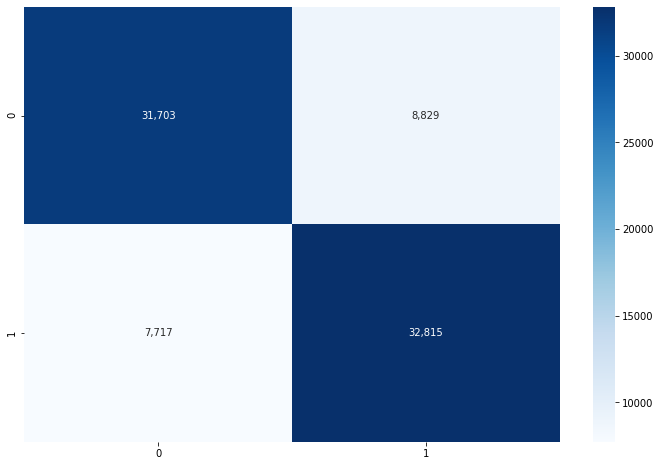

In [ ]:
cm = confusion_matrix(y_train, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     40532
           1       0.79      0.81      0.80     40532

    accuracy                           0.80     81064
   macro avg       0.80      0.80      0.80     81064
weighted avg       0.80      0.80      0.80     81064



#### Accuracy, Precision, and Recall

In [ ]:
print('Accuracy Score:', round(accuracy_score(y_train, y_pred), 2))
print('Precision Score:', round(precision_score(y_train, y_pred), 2))
print('Recall Score:', round(recall_score(y_train, y_pred), 2))
print('ROC AUC Score:', round(roc_auc_score(y_train, y_pred), 2))

Accuracy Score: 0.8
Precision Score: 0.79
Recall Score: 0.81
ROC AUC Score: 0.8


#### 5-fold Cross-Validation

In [ ]:
accuracy_cv = cross_val_score(gbc, X_train ,y_train ,cv=5 ,scoring='accuracy')
precision_cv = cross_val_score(gbc, X_train ,y_train ,cv=5 ,scoring='precision')
recall_cv = cross_val_score(gbc, X_train ,y_train ,cv=5 ,scoring='recall')
roc_auc_cv = cross_val_score(gbc, X_train ,y_train ,cv=5 ,scoring='roc_auc')

gbc_accuracy_cv = abs(accuracy_cv.mean())
gbc_precision_cv = abs(precision_cv.mean())
gbc_recall_cv = abs(recall_cv.mean())
gbc_roc_auc_cv = abs(roc_auc_cv.mean())

print('Accuracy (CV mean) :', round(gbc_accuracy_cv, 2))
print('Precision (CV mean) :', round(gbc_precision_cv, 2))
print('Recall (CV mean) :', round(gbc_recall_cv, 2))
print('ROC AUC (CV mean) :', round(gbc_roc_auc_cv, 2))

Accuracy (CV mean) : 0.79
Precision (CV mean) : 0.79
Recall (CV mean) : 0.81
ROC AUC (CV mean) : 0.88


### Random Forest Classifier

Random Forests consists of a number of decision trees being estimated. This means a diverse set of classifiers is created by introducing randomness in the classifier construction. The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

In random forests, each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. 

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees 

On first run, the Random Forest is the best performer but this needs to be taken with extreme caution. Despite scores of 0.97 for Accuaracy, Precision and Recall - we have yet to tune any of the parameter for this model meaning the no max depth has been set. This likely means the model is overfit. This already shown by the drop in performance in the 5-fold cross-validation.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf.predict(X_train)

#### Confusion Matrix and Classification Report

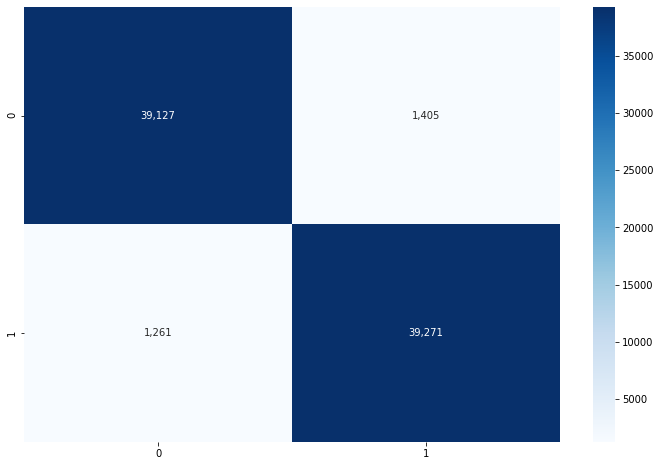

In [ ]:
cm = confusion_matrix(y_train, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     40532
           1       0.97      0.97      0.97     40532

    accuracy                           0.97     81064
   macro avg       0.97      0.97      0.97     81064
weighted avg       0.97      0.97      0.97     81064



#### Accuracy, Precision, and Recall

In [ ]:
print('Accuracy Score:', round(accuracy_score(y_train, y_pred), 2))
print('Precision Score:', round(precision_score(y_train, y_pred), 2))
print('Recall Score:', round(recall_score(y_train, y_pred), 2))
print('ROC AUC Score:', round(roc_auc_score(y_train, y_pred), 2))

Accuracy Score: 0.97
Precision Score: 0.97
Recall Score: 0.97
ROC AUC Score: 0.97


#### 5-fold Cross-Validation

In [ ]:
accuracy_cv = cross_val_score(rf, X_train ,y_train ,cv=5 ,scoring='accuracy')
precision_cv = cross_val_score(rf, X_train ,y_train ,cv=5 ,scoring='precision')
recall_cv = cross_val_score(rf, X_train ,y_train ,cv=5 ,scoring='recall')
roc_auc_cv = cross_val_score(rf, X_train ,y_train ,cv=5 ,scoring='roc_auc')

rf_accuracy_cv = abs(accuracy_cv.mean())
rf_precision_cv = abs(precision_cv.mean())
rf_recall_cv = abs(recall_cv.mean())
rf_roc_auc_cv = abs(roc_auc_cv.mean())

print('Accuracy (CV mean) :', round(rf_accuracy_cv, 2))
print('Precision (CV mean) :', round(rf_precision_cv, 2))
print('Recall (CV mean) :', round(rf_recall_cv, 2))
print('ROC AUC (CV mean) :', round(rf_roc_auc_cv, 2))

Accuracy (CV mean) : 0.9
Precision (CV mean) : 0.92
Recall (CV mean) : 0.89
ROC AUC (CV mean) : 0.96


## Tuning Hyper-parameters

Based on the initial runs of the model, it seems as if the two ensemble models of Gradient Boosting Classifier (GBC) and Random Forest (RF) have performed the best. Going forward, we will focus on these two models, along with the Logisitc Regression model as a a baseline model

### Logistic Regression

For the Logistic regresssion model, we will tune two hyper-parameters:
* C
* Penalty

We will do this using RandomizedSearchCV. RandomizedSearch is good to use as it is less computationally expensive as GridSearch (although for this example it will not make a signficant difference).

Running the search shows us that c=0.1 and penalty='l2' are the best parameters for our model on our data.

In [148]:
c_range = [0.001,0.01,0.1,1,10,100]
penalty = ['l1', 'l2']

param_distributions = dict(C=c_range, penalty=penalty)

In [149]:
from sklearn.model_selection import RandomizedSearchCV

logreg_cv = RandomizedSearchCV(estimator=logreg,
                            param_distributions=param_distributions,
                            scoring='accuracy', cv=5, n_jobs=-1,
                            n_iter=1000, random_state=23)

logreg_cv.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 12 is smaller than n_iter=1000. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=31,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=1000, n_jobs=-1,
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'penalty': ['l1', 'l2']},
                   pre_dispatch='2*n_jobs', random_state=23, refit=True,
                   return_train_score=False, scoring='accuracy', ve

In [150]:
print('Best Accuracy Score: ', round(abs(logreg_cv.best_score_), 2))
print('Best Params: ', logreg_cv.best_params_)

Best Accuracy Score:  0.73
Best Params:  {'penalty': 'l2', 'C': 0.1}


### Gradient Boosting

For the GBC model, we will look to tune six hyper-parameters:
* n_estimators
* max_depth
* learning_rate
* min_samples_leaf
* min_samples_split
* max_features

Running this using RandomizedSearchCV, gave us the following parameters:
* learning_rate=0.01
* max_depth=7
* max_features='auto'
* min_samples_leaf=2
* min_samples_split=2
* n_estimators=500

In [151]:
n_estimators =[250,500, 1000]
max_depth = [3,5,7,9]
learning_rate = [0.01,0.1,1,10,100]
min_samples_leaf = [1, 2, 10, 20]
min_samples_split = [2, 4, 20, 40]
max_features = ['auto', 'sqrt', 'log2']
#criterion = ['friedman_mse', 'mse', 'mae']

param_distributions = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, max_features=max_features)

In [152]:
gbc_cv = RandomizedSearchCV(estimator=gbc,
                            param_distributions=param_distributions,
                            scoring='accuracy', cv=5, n_jobs=-1,
                            n_iter=10, random_state=23, verbose=1)

gbc_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 33.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [153]:
print('Best Accuracy Score: ', round(abs(gbc_cv.best_score_), 2))
print('Best Params: ', gbc_cv.best_params_)

Best Accuracy Score:  0.93
Best Params:  {'n_estimators': 1000, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 9, 'learning_rate': 0.1}


### Random Forest 

For the RF model, we will look to tune six hyper-parameters:
* n_estimators
* max_depth
* min_samples_leaf
* min_samples_split
* max_features
* criterion

Running this using RandomizedSearchCV gave us the following parameters:
* max_depth=9
* max_features='LOG2'
* min_samples_leaf=20
* min_samples_split=4
* n_estimators=250
* criterion = 'gini'

In [154]:
n_estimators =[100,500,1000]
max_depth = [3,5,7,9]
min_samples_leaf = [1, 2, 10, 20]
min_samples_split = [2, 4, 20, 40]
max_features = ['auto', 'sqrt', 'log2']
criterion = ['gini', 'entropy']

param_distributions = dict(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                           min_samples_split=min_samples_split, max_features=max_features, criterion=criterion)

In [155]:
rf_cv = RandomizedSearchCV(estimator=rf,
                            param_distributions=param_distributions,
                            scoring='accuracy', cv=5, n_jobs=-1,
                            n_iter=60, random_state=23, verbose=1)

rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 50.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 74.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [156]:
print('Best Accuracy Score: ', round(abs(rf_cv.best_score_), 2))
print('Best Params: ', rf_cv.best_params_)

Best Accuracy Score:  0.79
Best Params:  {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 9, 'criterion': 'gini'}


## Optimal Models

### Logistic Regression

Now that we have identified the optimal Logistic Regression parameters for our model, we can apply it our training data to see how it performs.

I will run all the models first and comment on their performance in last section.

#### Run Model

In [ ]:
logreg_opt = LogisticRegression(C=0.1, penalty='l2', random_state=31)

logreg_opt.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=31, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = logreg_opt.predict(X_train)

y_pred_prob = logreg_opt.predict_proba(X_train)
y_pred_prob = y_pred_prob[:,1]

#### Confusion Matrix and Classification Report

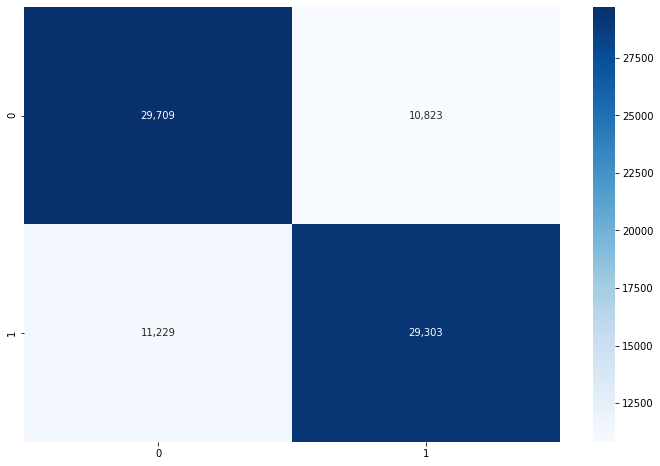

In [ ]:
cm = confusion_matrix(y_train, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73     40532
           1       0.73      0.72      0.73     40532

    accuracy                           0.73     81064
   macro avg       0.73      0.73      0.73     81064
weighted avg       0.73      0.73      0.73     81064



#### Accuracy, Precision and Recall

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve

In [ ]:
logreg_opt_accuracy = round(accuracy_score(y_train, y_pred), 2)
logreg_opt_precision = round(precision_score(y_train, y_pred), 2)
logreg_opt_recall = round(recall_score(y_train, y_pred), 2)

logreg_opt_roc_auc = round(roc_auc_score(y_train, y_pred_prob), 2)
logreg_opt_pr_auc = round(average_precision_score(y_train, y_pred_prob), 2)

print('Accuracy Score:', logreg_opt_accuracy)
print('Precision Score:', logreg_opt_precision)
print('Recall Score:', logreg_opt_recall)

#print('ROC AUC Score:', logreg_opt_roc_auc)
#print('PR AUC Score:', logreg_opt_pr_auc)

Accuracy Score: 0.73
Precision Score: 0.73
Recall Score: 0.72


#### ROC Curve

In [ ]:
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('ROC curve',fontsize=18)

AUC:  0.8


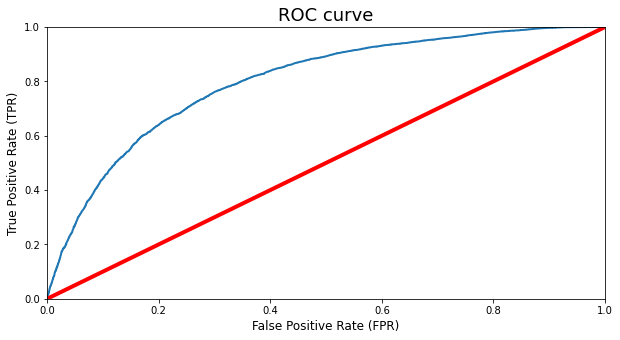

In [ ]:
print('AUC: ', logreg_opt_roc_auc)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred_prob)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
#plt.savefig("30.png")
plt.show()

#### Precision-Recall Curve

In [ ]:
def plot_pr_curve(recall, precision, label=None):
    plt.plot(recall, precision, linewidth=2, label=label)
    plt.axis([0, 1, 0, 1])
    plt.axhline(0.5, color='r', linewidth=2, linestyle='--')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall curve: ' 'AP={0:0.2f}'.format(average_precision), fontsize=18)

AUC:  0.78


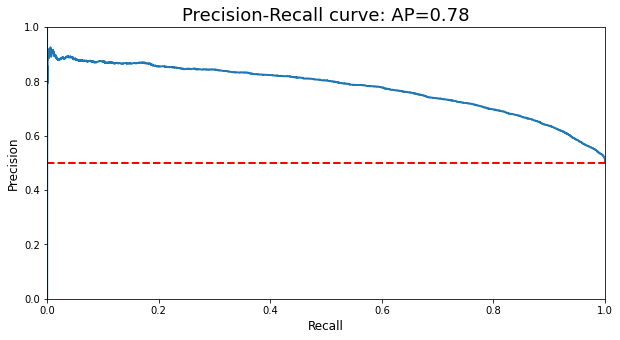

In [ ]:
print('AUC: ', logreg_opt_pr_auc)

average_precision = average_precision_score(y_train, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_prob)

_ = plt.figure(figsize=(10, 5))
_ = plot_pr_curve(recall, precision)
#_ = sns.despine()
plt.show()

#### 5-fold Cross-Validation

In [ ]:
accuracy_cv = cross_val_score(logreg_opt, X_train ,y_train ,cv=5 ,scoring='accuracy')
precision_cv = cross_val_score(logreg_opt, X_train ,y_train ,cv=5 ,scoring='precision')
recall_cv = cross_val_score(logreg_opt, X_train ,y_train ,cv=5 ,scoring='recall')
roc_auc_cv = cross_val_score(logreg_opt, X_train ,y_train ,cv=5 ,scoring='roc_auc')
pr_auc_cv = cross_val_score(logreg_opt, X_train ,y_train ,cv=5 ,scoring='average_precision')

logreg_opt_accuracy_cv = abs(accuracy_cv.mean())
logreg_opt_precision_cv = abs(precision_cv.mean())
logreg_opt_recall_cv = abs(recall_cv.mean())
logreg_opt_roc_auc_cv = abs(roc_auc_cv.mean())
logreg_opt_pr_auc_cv = abs(pr_auc_cv.mean())

print('Accuracy (CV mean) :', round(logreg_opt_accuracy_cv, 2))
print('Precision (CV mean) :', round(logreg_opt_precision_cv, 2))
print('Recall (CV mean) :', round(logreg_opt_recall_cv, 2))
print('ROC AUC (CV mean) :', round(logreg_opt_roc_auc_cv, 2))
print('PR AUC (CV mean) :', round(logreg_opt_pr_auc_cv, 2))

Accuracy (CV mean) : 0.73
Precision (CV mean) : 0.73
Recall (CV mean) : 0.72
ROC AUC (CV mean) : 0.8
PR AUC (CV mean) : 0.78


### Gradient Boosting

Apply optimal paramaters identified during hyper-parameter tuning on training data and record results.

#### Run the Model

In [ ]:
gbc_opt = GradientBoostingClassifier(learning_rate=0.01, max_depth=7,max_features='auto', 
                           min_samples_leaf=2, min_samples_split=2, n_estimators=500, random_state=23)

gbc_opt.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=7,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=23, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred = gbc_opt.predict(X_train)

y_pred_prob = gbc_opt.predict_proba(X_train)
y_pred_prob = y_pred_prob[:,1]

#### Confusion Matrix and Classification Report

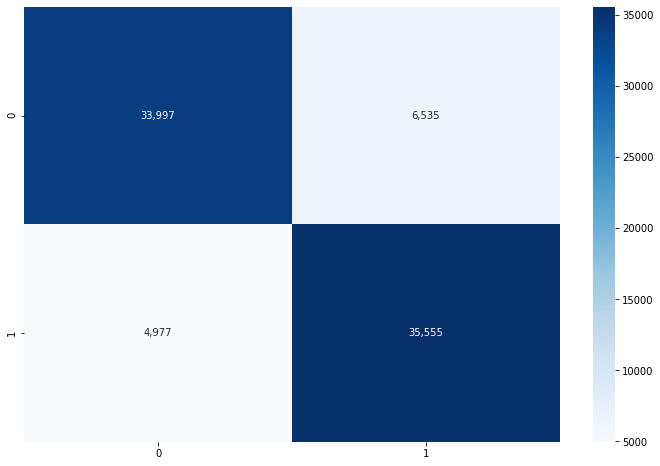

In [ ]:
cm = confusion_matrix(y_train, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86     40532
           1       0.84      0.88      0.86     40532

    accuracy                           0.86     81064
   macro avg       0.86      0.86      0.86     81064
weighted avg       0.86      0.86      0.86     81064



#### Accuracy, Precision & Recall

In [ ]:
gbc_opt_accuracy = round(accuracy_score(y_train, y_pred), 2)
gbc_opt_precision = round(precision_score(y_train, y_pred), 2)
gbc_opt_recall = round(recall_score(y_train, y_pred), 2)

gbc_opt_roc_auc = round(roc_auc_score(y_train, y_pred_prob), 2)
gbc_opt_pr_auc = round(average_precision_score(y_train, y_pred_prob), 2)

print('Accuracy Score:', gbc_opt_accuracy)
print('Precision Score:', gbc_opt_precision)
print('Recall Score:', gbc_opt_recall)

#print('ROC AUC Score:', gbc_opt_roc_auc)
#print('PR AUC Score:', gbc_opt_pr_auc)

Accuracy Score: 0.86
Precision Score: 0.84
Recall Score: 0.88


#### ROC Curve

AUC:  0.93


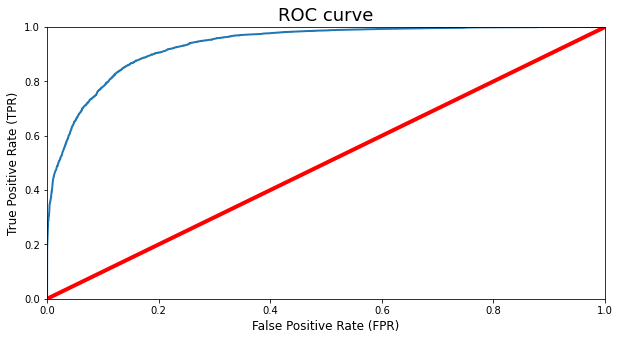

In [ ]:
print('AUC: ', gbc_opt_roc_auc)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred_prob)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
#plt.savefig("30.png")
plt.show()

#### Precision-Recall Curve

AUC:  0.93


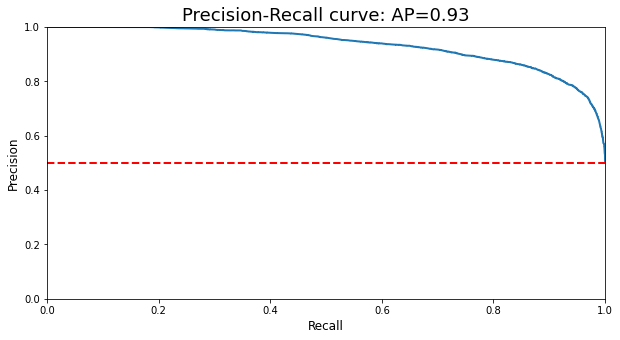

In [ ]:
print('AUC: ', gbc_opt_pr_auc)

average_precision = average_precision_score(y_train, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_prob)

_ = plt.figure(figsize=(10, 5))
_ = plot_pr_curve(recall, precision)
#_ = sns.despine()
plt.show()

#### 5-fold Cross Validation

In [ ]:
accuracy_cv = cross_val_score(gbc_opt, X_train ,y_train ,cv=5 ,scoring='accuracy')
precision_cv = cross_val_score(gbc_opt, X_train ,y_train ,cv=5 ,scoring='precision')
recall_cv = cross_val_score(gbc_opt, X_train ,y_train ,cv=5 ,scoring='recall')
roc_auc_cv = cross_val_score(gbc_opt, X_train ,y_train ,cv=5 ,scoring='roc_auc')
pr_auc_cv = cross_val_score(gbc_opt, X_train ,y_train ,cv=5 ,scoring='average_precision')

gbc_opt_accuracy_cv = abs(accuracy_cv.mean())
gbc_opt_precision_cv = abs(precision_cv.mean())
gbc_opt_recall_cv = abs(recall_cv.mean())
gbc_opt_roc_auc_cv = abs(roc_auc_cv.mean())
gbc_opt_pr_auc_cv = abs(pr_auc_cv.mean())

print('Accuracy (CV mean) :', round(gbc_opt_accuracy_cv, 2))
print('Precision (CV mean) :', round(gbc_opt_precision_cv, 2))
print('Recall (CV mean) :', round(gbc_opt_recall_cv, 2))
#print('ROC AUC (CV mean) :', round(gbc_opt_roc_auc_cv, 2))
#print('PR AUC (CV mean) :', round(gbc_opt_pr_auc_cv, 2))

Accuracy (CV mean) : 0.85
Precision (CV mean) : 0.84
Recall (CV mean) : 0.87


In [ ]:
#pr_auc_cv = cross_val_score(gbc_opt, X_train ,y_train ,cv=5 ,scoring='average_precision')
#gbc_opt_pr_auc_cv = abs(pr_auc_cv.mean())
#print('PR AUC (CV mean) :', round(gbc_opt_pr_auc_cv, 2))

### Random Forest

Apply optimal paramaters identified during hyper-parameter tuning on training data and record results.

#### Run the Model

In [ ]:
rf_opt = RandomForestClassifier(criterion='gini', max_depth=9, max_features='log2', min_samples_leaf=20, min_samples_split=4, n_estimators=250, random_state=43)

rf_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=43, verbose=0,
                       warm_start=False)

In [ ]:
y_pred = rf_opt.predict(X_train)

y_pred_prob = gbc_opt.predict_proba(X_train)
y_pred_prob = y_pred_prob[:,1]

#### Confusion Matrix & Classification Report

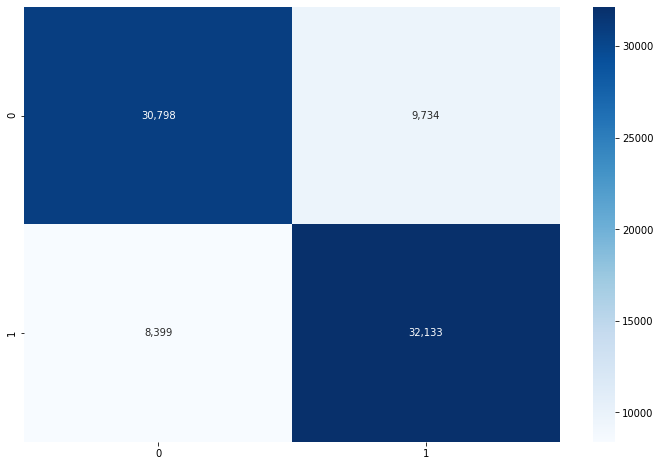

In [ ]:
cm = confusion_matrix(y_train, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77     40532
           1       0.77      0.79      0.78     40532

    accuracy                           0.78     81064
   macro avg       0.78      0.78      0.78     81064
weighted avg       0.78      0.78      0.78     81064



#### Accuracy, Precision and Recall

In [ ]:
rf_opt_accuracy = round(accuracy_score(y_train, y_pred), 2)
rf_opt_precision = round(precision_score(y_train, y_pred), 2)
rf_opt_recall = round(recall_score(y_train, y_pred), 2)

rf_opt_roc_auc = round(roc_auc_score(y_train, y_pred_prob), 2)
rf_opt_pr_auc = round(average_precision_score(y_train, y_pred_prob), 2)

print('Accuracy Score:', rf_opt_accuracy)
print('Precision Score:', rf_opt_precision)
print('Recall Score:', rf_opt_recall)

#print('ROC AUC Score:', rf_opt_roc_auc)
#print('PR AUC Score:', rf_opt_pr_auc)

Accuracy Score: 0.78
Precision Score: 0.77
Recall Score: 0.79


#### ROC Curve

AUC:  0.93


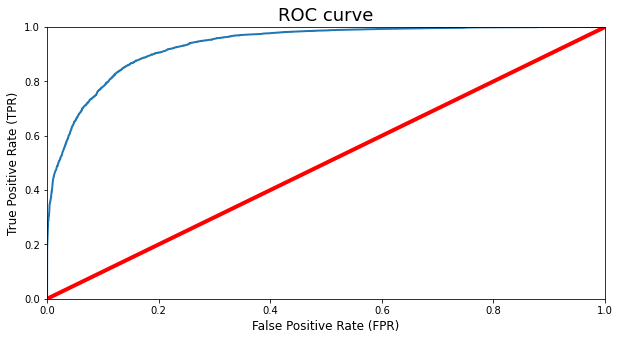

In [ ]:
print('AUC: ', rf_opt_roc_auc)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_pred_prob)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
#plt.savefig("30.png")
plt.show()

#### Precision-Recall Curve

AUC:  0.93


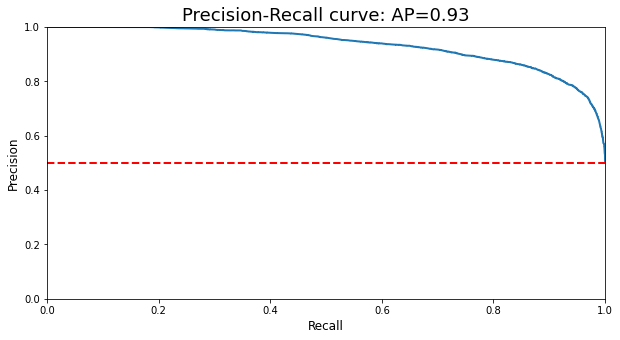

In [ ]:
print('AUC: ', rf_opt_pr_auc)

average_precision = average_precision_score(y_train, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred_prob)

_ = plt.figure(figsize=(10, 5))
_ = plot_pr_curve(recall, precision)
#_ = sns.despine()
plt.show()

#### 5-fold Cross Validation

In [ ]:
accuracy_cv = cross_val_score(rf_opt, X_train ,y_train ,cv=5 ,scoring='accuracy')
precision_cv = cross_val_score(rf_opt, X_train ,y_train ,cv=5 ,scoring='precision')
recall_cv = cross_val_score(rf_opt, X_train ,y_train ,cv=5 ,scoring='recall')
roc_auc_cv = cross_val_score(rf_opt, X_train ,y_train ,cv=5 ,scoring='roc_auc')
pr_auc_cv = cross_val_score(rf_opt, X_train ,y_train ,cv=5 ,scoring='average_precision')

rf_opt_accuracy_cv = abs(accuracy_cv.mean())
rf_opt_precision_cv = abs(precision_cv.mean())
rf_opt_recall_cv = abs(recall_cv.mean())
rf_opt_roc_auc_cv = abs(roc_auc_cv.mean())
rf_opt_pr_auc_cv = abs(pr_auc_cv.mean())

print('Accuracy (CV mean) :', round(rf_opt_accuracy_cv, 2))
print('Precision (CV mean) :', round(rf_opt_precision_cv, 2))
print('Recall (CV mean) :', round(rf_opt_recall_cv, 2))
print('ROC AUC (CV mean) :', round(rf_opt_roc_auc_cv, 2))
print('PR AUC (CV mean) :', round(rf_opt_pr_auc_cv, 2))

Accuracy (CV mean) : 0.77
Precision (CV mean) : 0.77
Recall (CV mean) : 0.79
ROC AUC (CV mean) : 0.86
PR AUC (CV mean) : 0.84


In [ ]:
#pr_auc_cv = cross_val_score(rf_opt, X_train ,y_train ,cv=5 ,scoring='average_precision')
#rf_opt_pr_auc_cv = abs(pr_auc_cv.mean())
#print('PR AUC (CV mean) :', round(rf_opt_pr_auc_cv, 2))

### Compare Results

The results show that GBC is the performing the best across all metrics. Accuracy is at 0.86 with Precision slightly lower at 0.84 and Recall slightly higher at 0.88. Perfomance seems to be generalising based on the small variation between main results and cross-validation.

RF is second best performing with Accuracy of 0.78, Precision of 0.77, and Recall 0.79. Performance for these metrics is not impacted by CV but does see a drop off in performance in ROC and PR AUC scores between overall score and that with 5-fold CV.

Logisitic regression remains third with Accuracy and Precions of 0.73 and Recall 0.72.

#### Create Result DataFrame

In [ ]:
model_list = ['Logistic', 'Gradient Boosting', 'Random Forest']
data_type = ['Train', 'Train', 'Train']
accuracy_scores = [logreg_opt_accuracy, gbc_opt_accuracy, rf_opt_accuracy]
precision_scores = [logreg_opt_precision, gbc_opt_precision, rf_opt_precision]
recall_scores = [logreg_opt_recall, gbc_opt_recall, rf_opt_recall]
roc_auc_scores = [logreg_opt_roc_auc, gbc_opt_roc_auc, rf_opt_roc_auc]
pr_auc_scores = [logreg_opt_pr_auc, gbc_opt_pr_auc, rf_opt_pr_auc]
result_cols = ['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC']

In [ ]:
performance_df = pd.DataFrame(list(zip(model_list,data_type, accuracy_scores, precision_scores, recall_scores, roc_auc_scores, pr_auc_scores)), columns=result_cols)

In [ ]:
#_ = plt.figure(figsize=(12,6))
#_ = sns.barplot(x='Model', y='Accuracy', hue='Data', data=performance_df, palette='Blues')
#_ = plt.title('Accuracy by Model and Data Type', fontsize=20)
#_ = plt.legend(loc='upper left')
#_ = plt.ylim([0, 1])

#plt.show()

In [ ]:
model_list = ['Logistic', 'Gradient Boosting', 'Random Forest']
data_type = ['Train CV', 'Train CV', 'Train CV']
accuracy_scores = [logreg_opt_accuracy_cv, gbc_opt_accuracy_cv, rf_opt_accuracy_cv]
precision_scores = [logreg_opt_precision_cv, gbc_opt_precision_cv, rf_opt_precision_cv]
recall_scores = [logreg_opt_recall_cv, gbc_opt_recall_cv, rf_opt_recall_cv]
roc_auc_scores = [logreg_opt_roc_auc_cv, gbc_opt_roc_auc_cv, rf_opt_roc_auc_cv]
pr_auc_scores = [logreg_opt_pr_auc_cv, gbc_opt_pr_auc_cv, rf_opt_pr_auc_cv]
result_cols = ['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC']

In [ ]:
performance_df_cv = pd.DataFrame(list(zip(model_list,data_type, accuracy_scores, precision_scores, recall_scores, roc_auc_scores, pr_auc_scores)), columns=result_cols)

In [ ]:
#_ = plt.figure(figsize=(12,6))
#_ = sns.barplot(x='Model', y='Accuracy', hue='Data', data=performance_df_cv, palette='Blues')
#_ = plt.title('Accuracy by Model and Data Type', fontsize=20)
#_ = plt.legend(loc='upper left')
#_ = plt.ylim([0, 1])

#plt.show()

In [ ]:
performance = pd.concat([performance_df, performance_df_cv]).reset_index().drop(columns='index')

#### Accuracy

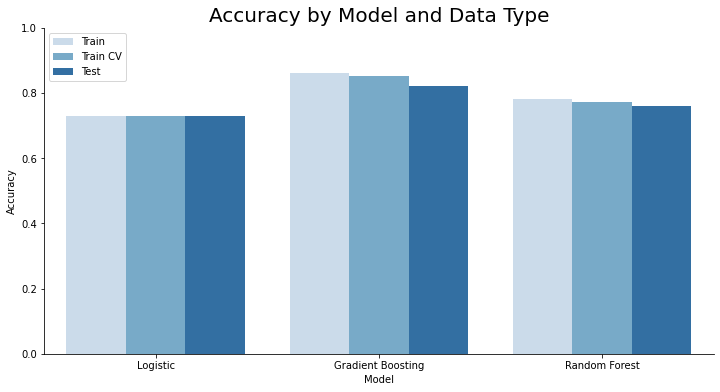

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Test      0.730000           0.820000       0.760000
Train     0.730000           0.860000       0.780000
Train CV  0.727795           0.851488       0.773068


In [157]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='Accuracy', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('Accuracy by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='Accuracy', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

#[['Logistic', 'Random Forest', 'Gradient Boosting']]

#### Precision

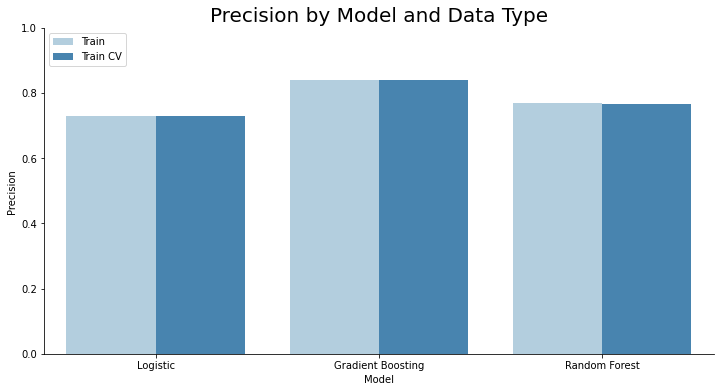

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Train     0.730000           0.840000        0.77000
Train CV  0.730148           0.839793        0.76598


In [ ]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='Precision', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('Precision by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='Precision', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

#[['Logistic', 'Random Forest', 'Gradient Boosting']]

#### Recall

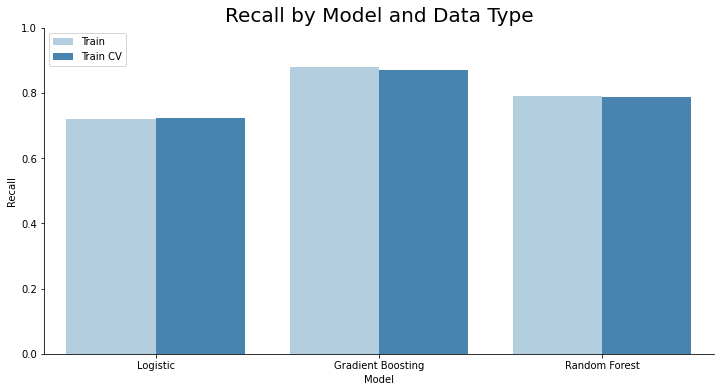

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Train     0.720000           0.880000       0.790000
Train CV  0.722713           0.868843       0.786366


In [ ]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='Recall', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('Recall by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='Recall', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

#[['Logistic', 'Random Forest', 'Gradient Boosting']]

#### ROC AUC

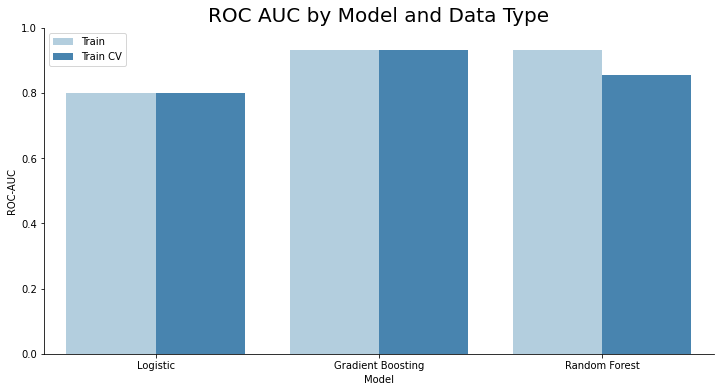

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Train     0.800000           0.930000       0.930000
Train CV  0.799007           0.930101       0.855209


In [ ]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='ROC-AUC', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('ROC AUC by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='ROC-AUC', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

#### Precision Recall AUC

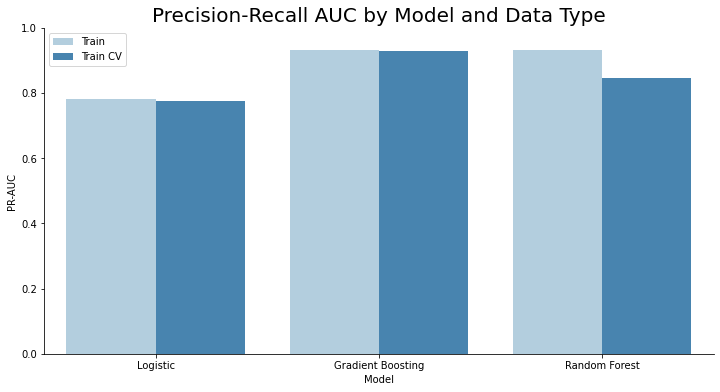

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Train     0.780000           0.930000       0.930000
Train CV  0.775964           0.929138       0.844329


In [ ]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='PR-AUC', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('Precision-Recall AUC by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='PR-AUC', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

## Test Data

Having optimised the model and tested it on our training data (using cross-validation), we are now ready to apply to our test data. 

### Logistic Regression

We have an issue with the model. While accuracy has maintained from the training set at 0.73 - Precision has fallen dramatically to 0.13. This is reflected in the Precision Recall cureve where we have an AUC of 0.19 and not even being able to break the 0.5 barrier.



In [ ]:
y_pred = logreg_opt.predict(X_test)

y_pred_prob = logreg_opt.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]

#### Confusion Matrix and Classification Report

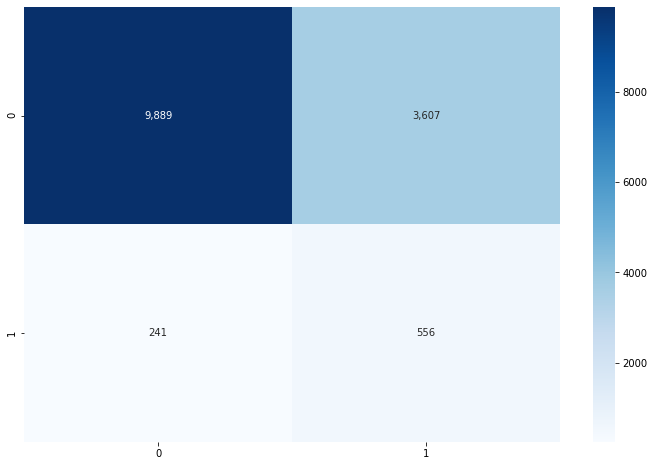

In [ ]:
cm = confusion_matrix(y_test, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.73      0.84     13496
           1       0.13      0.70      0.22       797

    accuracy                           0.73     14293
   macro avg       0.55      0.72      0.53     14293
weighted avg       0.93      0.73      0.80     14293



#### Accuracy, Precision & Recall

In [ ]:
logreg_test_accuracy = round(accuracy_score(y_test, y_pred), 2)
logreg_test_precision = round(precision_score(y_test, y_pred), 2)
logreg_test_recall = round(recall_score(y_test, y_pred), 2)

logreg_test_roc_auc = round(roc_auc_score(y_test, y_pred_prob), 2)
logreg_test_pr_auc = round(average_precision_score(y_test, y_pred_prob), 2)

print('Accuracy Score:', logreg_test_accuracy)
print('Precision Score:', logreg_test_precision)
print('Recall Score:', logreg_test_recall)

#print('ROC AUC Score:', gbc_test_roc_auc)
#print('PR AUC Score:', gbc_test_pr_auc)

Accuracy Score: 0.73
Precision Score: 0.13
Recall Score: 0.7


#### ROC Curve

AUC:  0.78


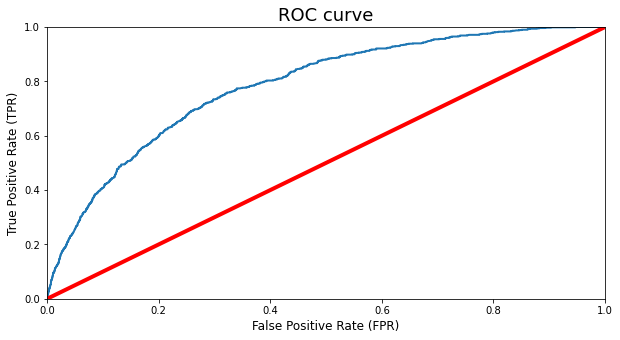

In [ ]:
print('AUC: ', logreg_test_roc_auc)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
#plt.savefig("30.png")
plt.show()

#### Precision-Recall Curve

AUC:  0.19


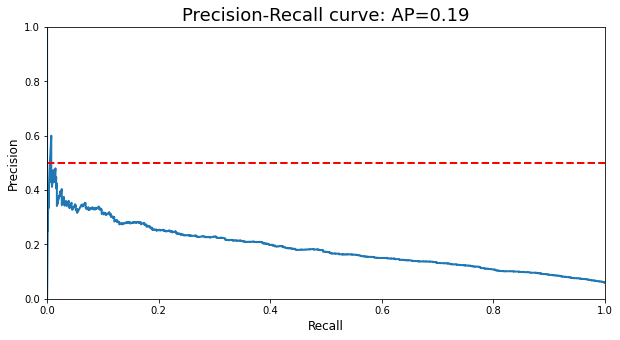

In [ ]:
print('AUC: ', logreg_test_pr_auc)

average_precision = average_precision_score(y_test, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

_ = plt.figure(figsize=(10, 5))
_ = plot_pr_curve(recall, precision)
#_ = sns.despine()
plt.show()

#### Feature Importance

In [ ]:
logreg_feature_imp = pd.DataFrame({'Features': list(X_rfecv.columns), 'Coefficients': list(logreg.coef_[0])} )

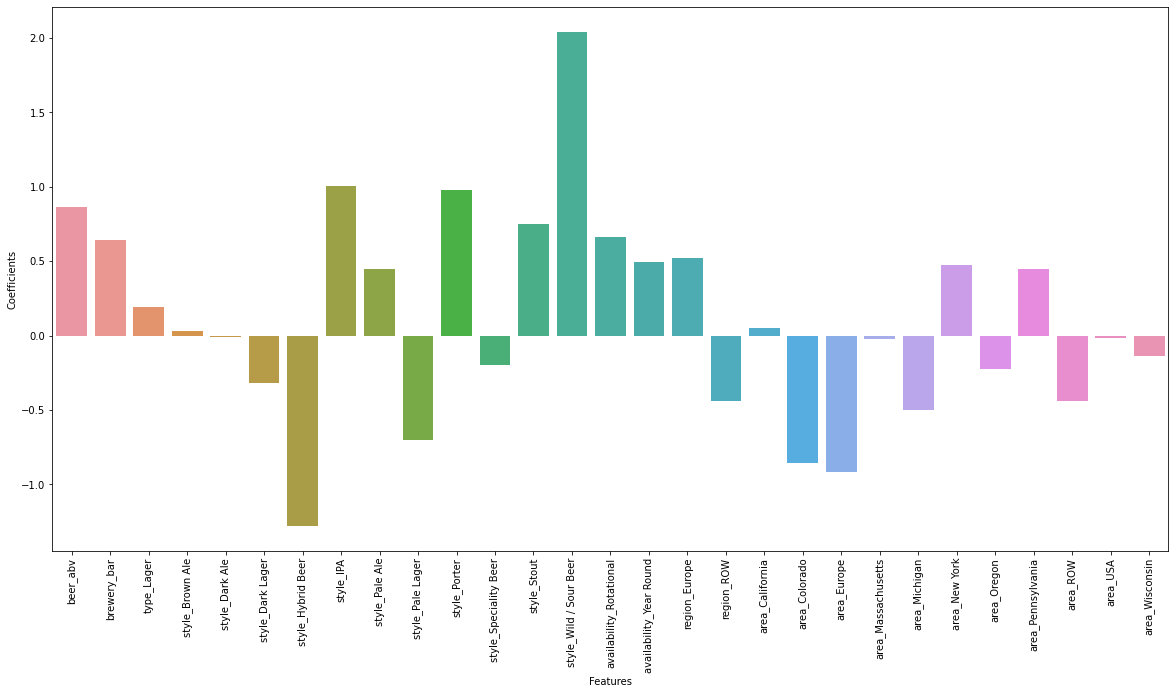

In [ ]:
_ = plt.figure(figsize=(20,10))
_ = sns.barplot(data=logreg_feature_imp, x='Features', y='Coefficients')
_ = plt.xticks(rotation=90, fontsize=10)

plt.show()

### Gradient Boosting

#### Run Model on Test Data

The main difference between predict_proba() and predict() methods is that predict_proba() gives the probabilities of each target class. Whereas, predict() gives the actual prediction as to which class will occur for a given set of features.

In [ ]:
y_pred = gbc_opt.predict(X_test)

y_pred_prob = gbc_opt.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]

#### Confusion Matrix and Classification Report

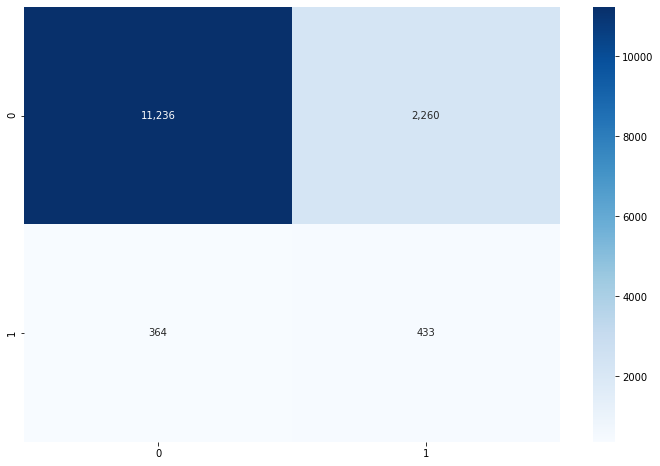

In [ ]:
cm = confusion_matrix(y_test, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90     13496
           1       0.16      0.54      0.25       797

    accuracy                           0.82     14293
   macro avg       0.56      0.69      0.57     14293
weighted avg       0.92      0.82      0.86     14293



#### Accuracy, Precision and Recall

In [ ]:
gbc_test_accuracy = round(accuracy_score(y_test, y_pred), 2)
gbc_test_precision = round(precision_score(y_test, y_pred), 2)
gbc_test_recall = round(recall_score(y_test, y_pred), 2)

gbc_test_roc_auc = round(roc_auc_score(y_test, y_pred_prob), 2)
gbc_test_pr_auc = round(average_precision_score(y_test, y_pred_prob), 2)

print('Accuracy Score:', gbc_test_accuracy)
print('Precision Score:', gbc_test_precision)
print('Recall Score:', gbc_test_recall)

#print('ROC AUC Score:', gbc_test_roc_auc)
#print('PR AUC Score:', gbc_test_pr_auc)

Accuracy Score: 0.82
Precision Score: 0.16
Recall Score: 0.54


#### ROC Curve

AUC:  0.78


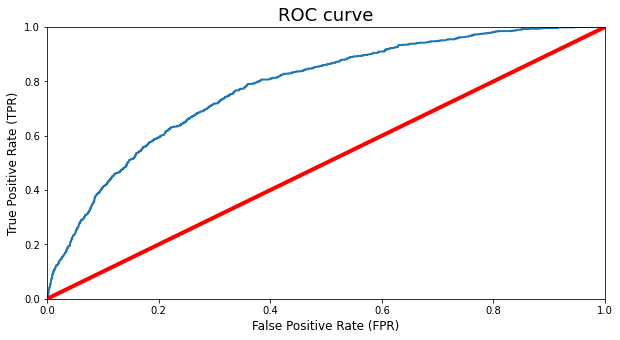

In [ ]:
print('AUC: ', gbc_test_roc_auc)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
#plt.savefig("30.png")
plt.show()

#### Precision Recall Curve

AUC:  0.18


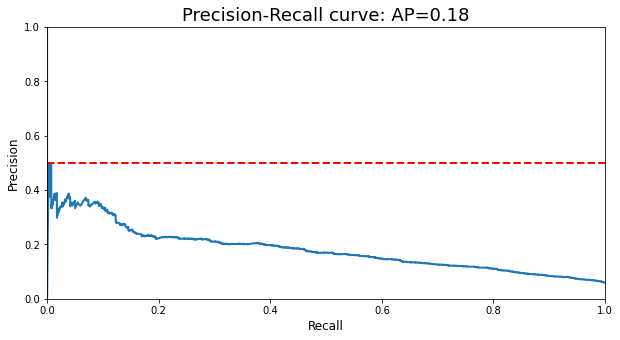

In [ ]:
print('AUC: ', gbc_test_pr_auc)

average_precision = average_precision_score(y_test, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

_ = plt.figure(figsize=(10, 5))
_ = plot_pr_curve(recall, precision)
#_ = sns.despine()
plt.show()

#### Feature Importance

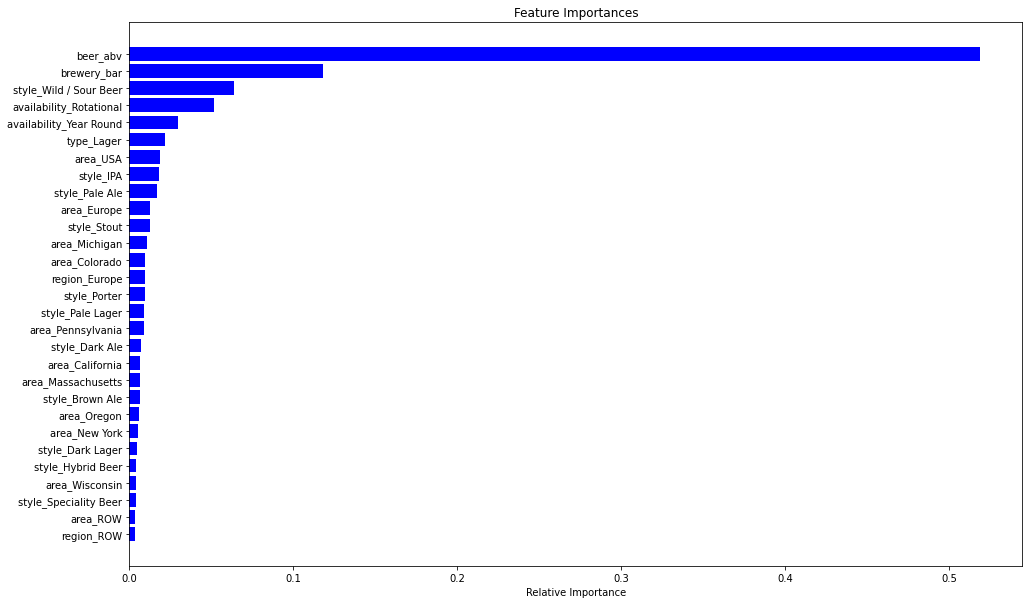

                   Features  Importance scores
0                  beer_abv           0.518527
1               brewery_bar           0.118158
13   style_Wild / Sour Beer           0.063981
14  availability_Rotational           0.051553
15  availability_Year Round           0.029440
2                type_Lager           0.021760
27                 area_USA           0.018578
7                 style_IPA           0.018237
8            style_Pale Ale           0.016734
20              area_Europe           0.012540
12              style_Stout           0.012499
22            area_Michigan           0.010844
19            area_Colorado           0.009786
16            region_Europe           0.009531
10             style_Porter           0.009502
9          style_Pale Lager           0.008971
25        area_Pennsylvania           0.008900
4            style_Dark Ale           0.007198
18          area_California           0.006594
21       area_Massachusetts           0.006322
3           s

In [ ]:
features = X_rfecv.columns
importances = gbc_opt.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

imp_table = pd.DataFrame(list(zip(features,importances)),columns =['Features', 'Importance scores'])
imp_table = imp_table.sort_values(by='Importance scores', ascending=False)
print(imp_table)

### Random Forest

#### Run Models on Test Data

In [ ]:
y_pred = rf_opt.predict(X_test)

y_pred_prob = rf_opt.predict_proba(X_test)
y_pred_prob = y_pred_prob[:,1]

#### Confusion Matrix & Classification Report

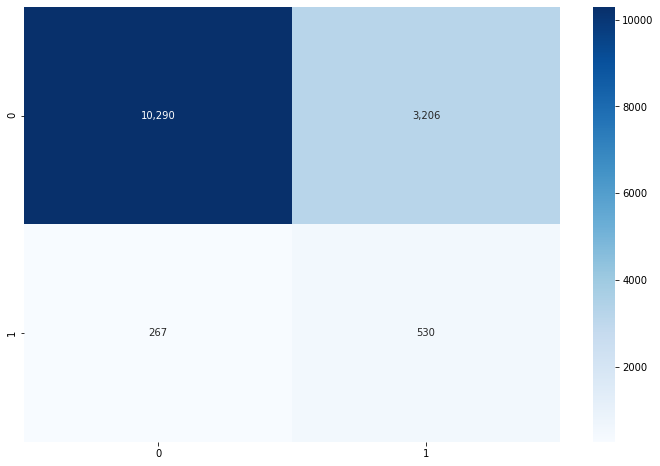

In [ ]:
cm = confusion_matrix(y_test, y_pred)

_ = plt.figure(figsize=(12,8))
_ = sns.heatmap(cm, annot=True, fmt=",", cmap='Blues')

plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.76      0.86     13496
           1       0.14      0.66      0.23       797

    accuracy                           0.76     14293
   macro avg       0.56      0.71      0.54     14293
weighted avg       0.93      0.76      0.82     14293



#### Accuracy, Precision & Recall

In [ ]:
rf_test_accuracy = round(accuracy_score(y_test, y_pred), 2)
rf_test_precision = round(precision_score(y_test, y_pred), 2)
rf_test_recall = round(recall_score(y_test, y_pred), 2)

rf_test_roc_auc = round(roc_auc_score(y_test, y_pred_prob), 2)
rf_test_pr_auc = round(average_precision_score(y_test, y_pred_prob), 2)

print('Accuracy Score:', rf_test_accuracy)
print('Precision Score:', rf_test_precision)
print('Recall Score:', rf_test_recall)

#print('ROC AUC Score:', rf_test_roc_auc)
#print('PR AUC Score:', rf_test_pr_auc)

Accuracy Score: 0.76
Precision Score: 0.14
Recall Score: 0.66


#### ROC Curve

AUC:  0.78


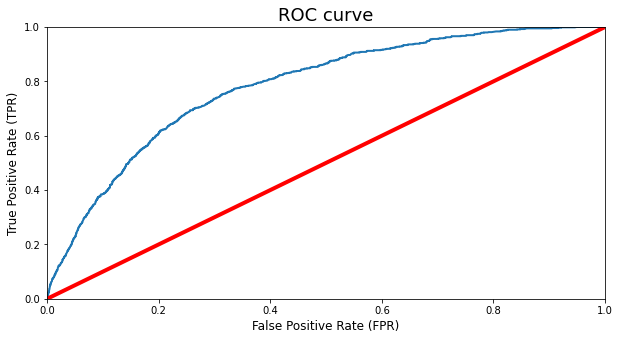

In [ ]:
print('AUC: ', rf_test_roc_auc)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
#plt.savefig("30.png")
plt.show()

#### Precision-Curve

AUC:  0.18


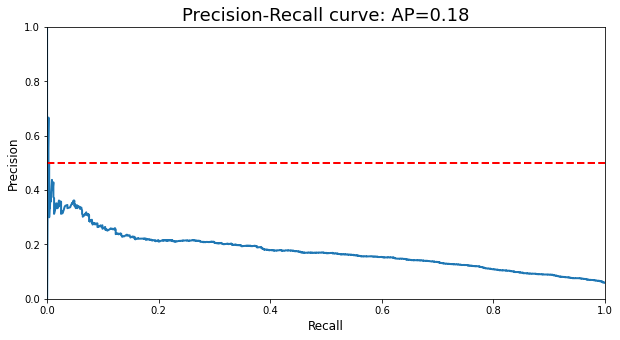

In [ ]:
print('AUC: ', rf_test_pr_auc)

average_precision = average_precision_score(y_test, y_pred_prob)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

_ = plt.figure(figsize=(10, 5))
_ = plot_pr_curve(recall, precision)
#_ = sns.despine()
plt.show()

#### Feature Importance

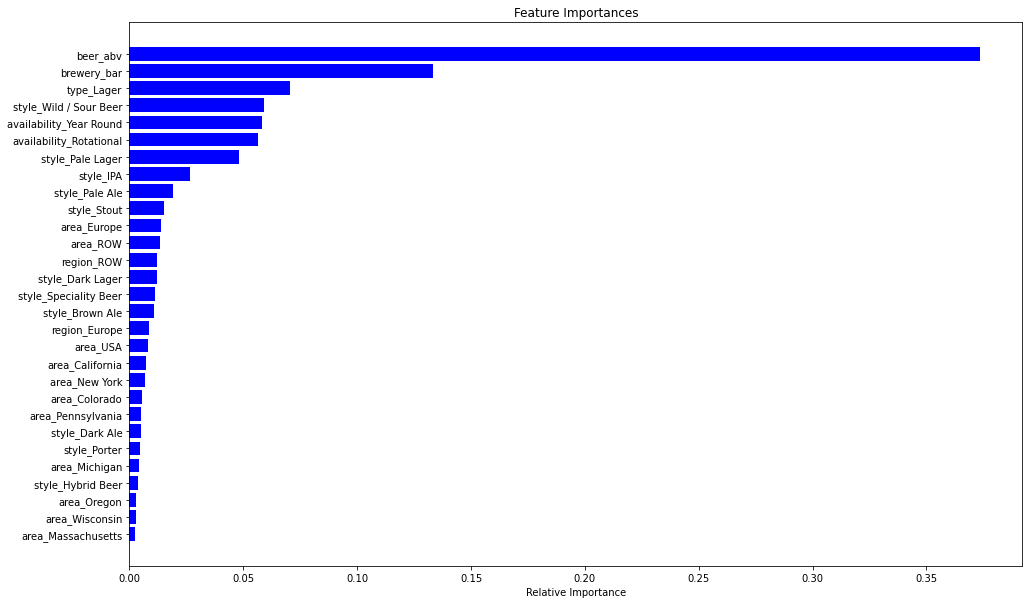

                   Features  Importance scores
0                  beer_abv           0.373398
1               brewery_bar           0.133224
2                type_Lager           0.070632
13   style_Wild / Sour Beer           0.059068
15  availability_Year Round           0.058303
14  availability_Rotational           0.056596
9          style_Pale Lager           0.047964
7                 style_IPA           0.026725
8            style_Pale Ale           0.018933
12              style_Stout           0.015206
20              area_Europe           0.013762
26                 area_ROW           0.013602
17               region_ROW           0.012050
5          style_Dark Lager           0.011895
11    style_Speciality Beer           0.011124
3           style_Brown Ale           0.010639
16            region_Europe           0.008720
27                 area_USA           0.008307
18          area_California           0.007271
23            area_New York           0.006657
19           

In [ ]:
features = X_rfecv.columns
importances = rf_opt.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

imp_table = pd.DataFrame(list(zip(features,importances)),columns =['Features', 'Importance scores'])
imp_table = imp_table.sort_values(by='Importance scores', ascending=False)
print(imp_table)

## Final Review

### Set up data

In [ ]:
model_list = ['Logistic', 'Gradient Boosting', 'Random Forest']
data_type = ['Test', 'Test', 'Test']
accuracy_scores = [logreg_test_accuracy, gbc_test_accuracy, rf_test_accuracy]
precision_scores = [logreg_test_precision, gbc_test_precision, rf_test_precision]
recall_scores = [logreg_test_recall, gbc_test_recall, rf_test_recall]
roc_auc_scores = [logreg_test_roc_auc, gbc_opt_roc_auc, rf_test_roc_auc]
pr_auc_scores = [logreg_test_pr_auc, gbc_test_pr_auc, rf_test_pr_auc]
result_cols = ['Model', 'Data', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC']

In [ ]:
performance_df_test = pd.DataFrame(list(zip(model_list,data_type, accuracy_scores, precision_scores, recall_scores, roc_auc_scores, pr_auc_scores)), columns=result_cols)

In [ ]:
performance = pd.concat([performance, performance_df_test]).reset_index().drop(columns='index')

### Accuracy

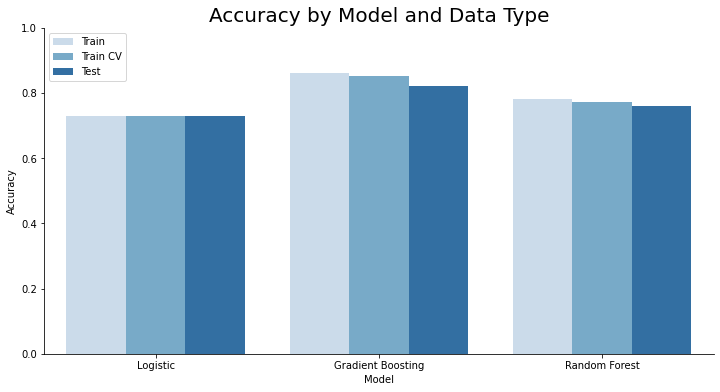

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Test      0.730000           0.820000       0.760000
Train     0.730000           0.860000       0.780000
Train CV  0.727795           0.851488       0.773068


In [ ]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='Accuracy', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('Accuracy by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='Accuracy', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

### Precision

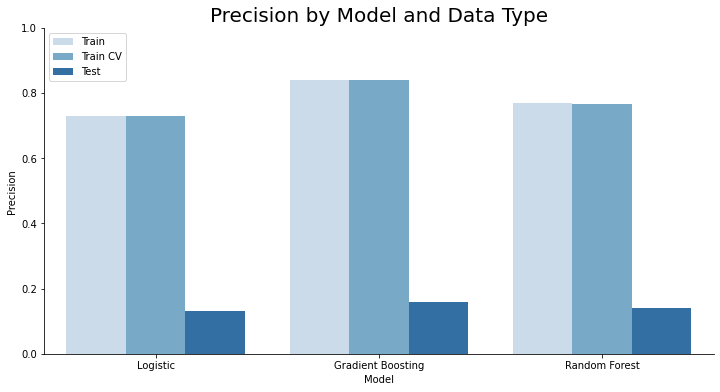

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Test      0.130000           0.160000        0.14000
Train     0.730000           0.840000        0.77000
Train CV  0.730148           0.839793        0.76598


In [144]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='Precision', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('Precision by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='Precision', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

### Recall

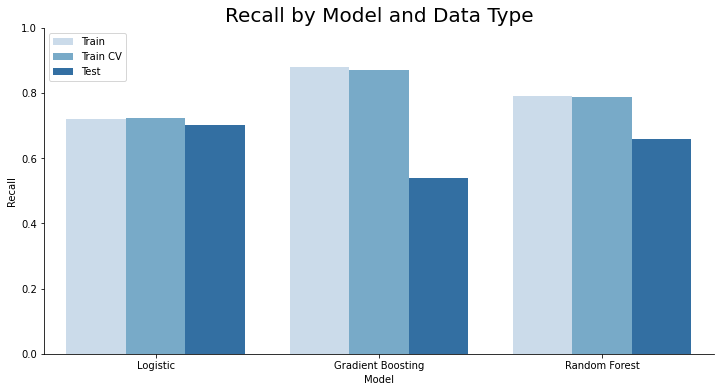

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Test      0.700000           0.540000       0.660000
Train     0.720000           0.880000       0.790000
Train CV  0.722713           0.868843       0.786366


In [145]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='Recall', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('Recall by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='Recall', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

#### ROC AUC

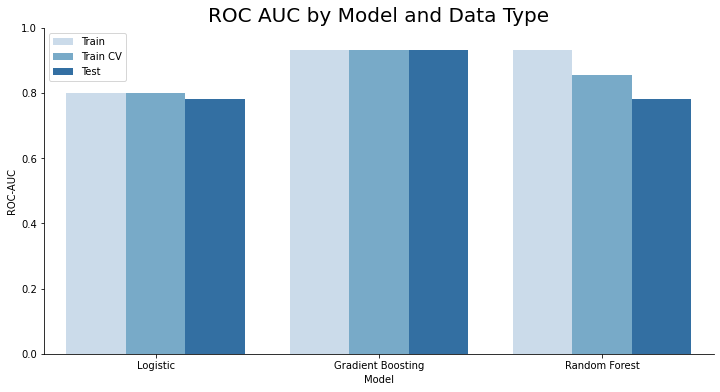

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Test      0.780000           0.930000       0.780000
Train     0.800000           0.930000       0.930000
Train CV  0.799007           0.930101       0.855209


In [146]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='ROC-AUC', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('ROC AUC by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='ROC-AUC', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

### Precision Recall AUC

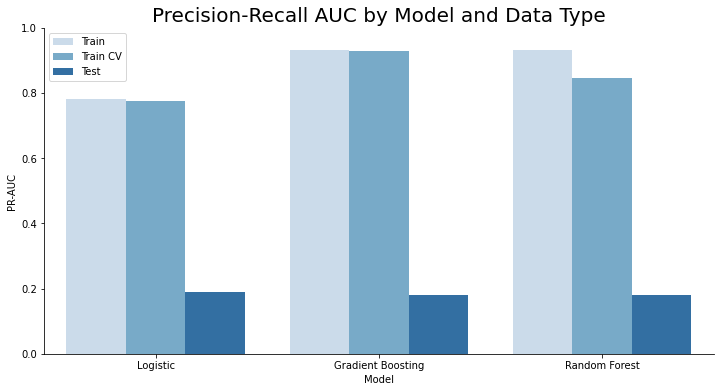

Model     Logistic  Gradient Boosting  Random Forest
Data                                                
Test      0.190000           0.180000       0.180000
Train     0.780000           0.930000       0.930000
Train CV  0.775964           0.929138       0.844329


In [147]:
_ = plt.figure(figsize=(12,6))
_ = sns.barplot(x='Model', y='PR-AUC', hue='Data', data=performance, palette='Blues')
_ = sns.despine()
_ = plt.title('Precision-Recall AUC by Model and Data Type', fontsize=20)
_ = plt.legend(loc='upper left')
_ = plt.ylim([0, 1])

plt.show()

print(performance.pivot(columns='Model', values='PR-AUC', index='Data')[['Logistic', 'Gradient Boosting', 'Random Forest']])

## Conclusion

The aim of this modelling was create a model that could identify our target group of beers (that were identify through our EDA / Beer Segmentations stage). To do this, we applied several steps:
1. Feature Elimination and Pre-processing of data
  * Dropping of N/A rows
  * Dropping of unnecessary columns
  * Creating dummy variables for categorical variables
  * Splitting out data into training and test
  * Scaling numeric features
  * Rebalancing our imbalanced dataset using imblearn's SMOTE method
  * More feature elimination using Recursive Feature elimination (with Random Forest Classifier and Cross-Validation)

2. Modelling
  * Five basic models applied to training data
    1. Logisitic Regression
    2. SGD Classifier
    3. Naive Bayes
    4. Gradient Boosting Classifier (GBC)
    5. Random Forest Classifier (RF)
  * Hypertuning of three of the Logistic Regression, GBC and RF models - as were best performing in initial run
  * Applying optimal hyper-paramaters to three models on training data and evaluating performance through variety of different metrics including:
    * Confusion Matrix
    * Classification Report 
    * Accuracy
    * Precision
    * Recall
    * Reciever Operating Characteristic (ROC) curve and Area Under the Curve (AUC)
    * Precision-Recall (PR) curve and AUC
  * Evaluating performance on training data using 5-fold cross-validation
  * Evaluating performance on test data



Results of the modelling were not what we were hoping for.

The key metric for us was Precision score. The aim is to minimise the number of False Positives due to the impact this would have on the brewery due to the cost in producing and marketing a new beer that would not be recouped in revenue if the beer is not successful. 

So while the accuracy of our models may seem fine on our test data, the low precision score across all models means that if would be very risky for the brewery to based their decision on the new type of brewery on any of these models.

To improve upon this model for next time, there are several different approaches that may be useful.

* Balancing Dataset
  * Try different techniques to understand impact to model
    * Undersampling instead of oversampling
    * No sampling
  * Reengineer data so that target class are not as imbalanced. This should be done in consulation with brewery management
  * Wait for more data to become available - our dataset only contained +3k rows of target data so greater availability of data on beers that have succeeded would help support modelling in future

* 
